### Time Domain Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display as ld

from tqdm import tqdm

In [2]:
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data

# Loading Data
def get_audio_ids(ids=None, indices=None, first_n=None, last_n=None, random_n=None, seed=None):
    all_audio_ids = get_codecfake_audio_id_list()
    
    if ids is not None:
        return ids
    elif indices is not None:
        return [all_audio_ids[i] for i in indices]
    elif first_n is not None:
        return all_audio_ids[:first_n]
    elif last_n is not None:
        return all_audio_ids[-last_n:]
    elif random_n is not None:
        if seed is not None:
            random.seed(seed)
        return random.sample(all_audio_ids, random_n)
    else:
        return all_audio_ids

def get_iterable_dataset(ids=None, indices=None, first_n=None, last_n=None, random_n=None, seed=None, cache_dir=None):
    audio_ids = get_audio_ids(ids=ids, indices=indices, first_n=first_n, last_n=last_n, random_n=random_n, seed=seed)
    iterable_dataset = load_audio_data(
        audio_ids=audio_ids,
        dataset='codecfake',
        cache_dir=cache_dir
    )
    return iterable_dataset


def resample_audio(audio_array, orig_sr, target_sr=16000):
    if orig_sr != target_sr:
        audio_array = librosa.resample(audio_array, orig_sr=orig_sr, target_sr=target_sr)
    return audio_array, target_sr

# Function to load and resample audio
def load_audio(audio_id, real_or_fake, resample=False):
    sample = next(sample for sample in get_iterable_dataset(ids=[audio_id]) if sample['audio_id'] == audio_id and sample['real_or_fake'] == real_or_fake)
    audio_array = sample['audio']['array']
    sampling_rate = sample['audio']['sampling_rate']
    if resample:
        audio_array, sampling_rate = resample_audio(audio_array, sampling_rate)
    return audio_array, sampling_rate

def load_audios(audio_ids, resample=False):
    if not isinstance(audio_ids, list):
        audio_ids = [audio_ids]
    samples = get_iterable_dataset(ids=audio_ids)
    audio_data = []

    for sample in tqdm(samples):
        audio_array   = sample['audio']['array']
        sampling_rate = sample['audio']['sampling_rate']
        audio_id      = sample['audio_id']
        real_or_fake  = sample['real_or_fake']
        
        if resample:
            audio_array, new_sampling_rate = resample_audio(audio_array, sampling_rate)
            audio_data.append((audio_array, new_sampling_rate, audio_id, real_or_fake))
        else:
            audio_data.append((audio_array, sampling_rate, audio_id, real_or_fake))

    return audio_data

##  Plot Time Domain (Waveforms)
def plot_audio_pair(f_audio, r_audio, fake_version, f_sr=16000, r_sr=16000, ylabel='Amplitude'):
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))
    
    # Plot fake audio waveform
    ld.waveshow(y=f_audio, sr=f_sr, ax=ax1)
    ax1.set_title(f'Fake {fake_version} Audio - sr: {f_sr}')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel(ylabel)
    
    # Plot real audio waveform
    ld.waveshow(y=r_audio, sr=r_sr, ax=ax2)
    ax2.set_title(f'Real Audio - sr: {r_sr}')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel(ylabel)
    
    plt.tight_layout()
    plt.show()

In [3]:
# Load subset of sample audios

all_audio_ids   = get_codecfake_audio_id_list()
audio_data_list = load_audios(all_audio_ids[:200], resample=True)

audio_df = pd.DataFrame(audio_data_list, columns=['audio_array', 'sample_rate', 'audio_id', 'real_or_fake'])


audio_df.head()


1400it [08:51,  2.64it/s]


,audio_array,sample_rate,audio_id,real_or_fake
0,"[-0.0036513032391667366, -0.006797592155635357...",16000,p225_002,R
1,"[0.001953125, 0.001556396484375, 0.00164794921...",16000,p225_002,F03
2,"[-0.001048615900799632, -0.0010888270335271955...",16000,p225_002,F04
3,"[0.001861572265625, 0.001922607421875, 0.00195...",16000,p225_002,F01
4,"[-0.002191566163673997, -0.0035043577663600445...",16000,p225_002,F05


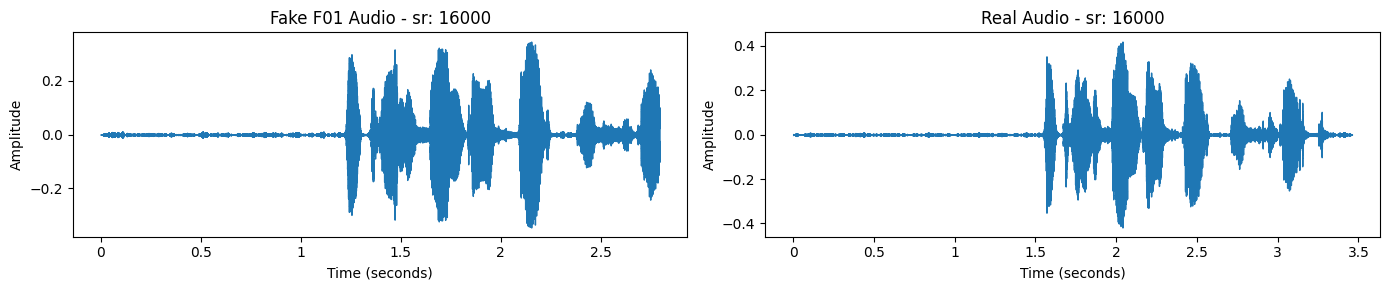

In [7]:
audio_id     = audio_df['audio_id'].sample(1).values[0]
audio_sample = audio_df[audio_df.audio_id == audio_id]

fake_version      = 'F01'


real_audio_sample = audio_sample[audio_sample['real_or_fake'] == 'R']
fake_audio_sample = audio_sample[audio_sample['real_or_fake'] == fake_version]

real_audio = real_audio_sample.iloc[0, 0]
fake_audio = fake_audio_sample.iloc[0, 0]
plot_audio_pair(fake_audio, real_audio, fake_version)

### Crest Factor

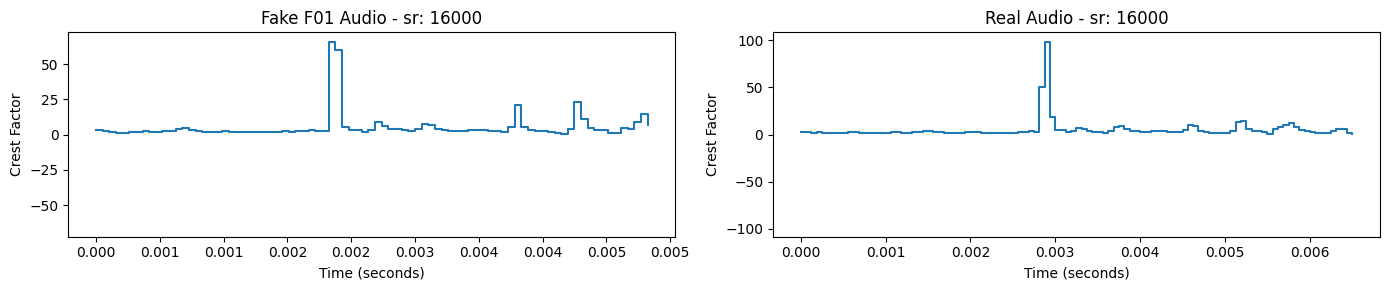

In [8]:
def calculate_crest_factor(audio, frame_length=2048, hop_length=512):
    rms_waveform = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length).flatten()
    peak_waveform = np.array([np.max(audio[i:i+frame_length]) for i in range(0, len(audio) - frame_length + 1, hop_length)])
    min_len = min(len(rms_waveform), len(peak_waveform))
    rms_waveform = rms_waveform[:min_len]
    peak_waveform = peak_waveform[:min_len]
    crest_factor_waveform = peak_waveform / rms_waveform
    return crest_factor_waveform


# Calculate crest factor waveforms
real_crest_waveform = calculate_crest_factor(real_audio)
fake_crest_waveform = calculate_crest_factor(fake_audio)

plot_audio_pair(fake_crest_waveform, real_crest_waveform, fake_version, ylabel='Crest Factor')

### Statistical Analysis to check if there is a significant difference in crest factor between Real vs Fake 

## FRAMEWORK

### 1. Create Potential Features
   * **Descriptive Statistics**: Summarize the given characteristic values of the audio.
     - Mean
     - Variance
     - Skewness
     - Kurtosis
     - Percentiles (10th, 25th, 50th, 75th, 90th)
     - Mean Peak Height
   * **Windowed Statistics Mean**: Calculate the mean of the windowed descriptive statistics for a given window size and step size.
     - Apply a sliding window to the audio data.
     - Calculate descriptive statistics for each window.
     - Aggregate the windowed statistics by calculating the mean for each feature.

### 2. Statistical Analysis Workflow

#### 2.1 Data Preparation
   * **Sliding Window**: Use a sliding window approach to segment the audio data.
   * **Calculate Statistics**:
     - For each window, compute descriptive statistics.
     - Aggregate windowed statistics by calculating their mean values.

#### 2.2 Hypothesis Testing
   * **Check Assumptions**:
     - Perform the Shapiro-Wilk test to check for normality.
     - Perform Levene's test to check for homogeneity of variances.
   * **Perform T-tests**:
     - Conduct t-tests to compare real and fake audio features, using Welch's correction if variances are unequal.
   * **Perform Mann-Whitney U Tests**:
     - Conduct Mann-Whitney U tests to compare real and fake audio features non-parametrically.

#### 2.3 Visualization
   * **Visualize Distributions**:
     - Plot histograms with KDE for real and fake audio feature distributions to qualitatively assess differences.
    
### 3. Interpretation of Results
   * **Evaluate P-values**:
     - Check the p-values from the t-tests and Mann-Whitney U tests. A p-value less than 0.05 typically indicates a statistically significant difference between real and fake audio features.
   * **Examine Test Statistics**:
     - Consider the magnitude of the test statistics (t-statistic and U statistic). Larger absolute values indicate stronger evidence against the null hypothesis.
   * **Assess Normality and Homogeneity**:
     - Review the results of the Shapiro-Wilk and Levene's tests to understand the assumptions behind the statistical tests.
   * **Visual Inspection**:
     - Use the visualizations to qualitatively assess the distributions of real and fake audio features. Look for noticeable differences in the shapes, spreads, and central tendencies of the distributions.
   * **Select Significant Features**:
     - Identify and select the features that show significant differences between real and fake audio data for further analysis or model building.

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
from scipy.stats import skew, kurtosis, mannwhitneyu
from scipy.signal import find_peaks


def sliding_window(data, window_size, step_size):
    num_windows = (len(data) - window_size) // step_size + 1
    windows = [data[i*step_size : i*step_size + window_size] for i in range(num_windows)]
    return windows

def calculate_statistics(values, features=None):
    peaks, _ = find_peaks(values)
    available_stats = {
        'mean': np.mean(values),
        'variance': np.var(values),
        'skewness': skew(values),
        'kurtosis': kurtosis(values),
        '10th_percentile': np.percentile(values, 10),
        '25th_percentile': np.percentile(values, 25),
        '50th_percentile': np.percentile(values, 50),
        '75th_percentile': np.percentile(values, 75),
        '90th_percentile': np.percentile(values, 90),
        'mean_peak_height': np.mean(values[peaks]) if len(peaks) > 0 else 0
    }
    
    if features:
        stats = {key: available_stats[key] for key in features if key in available_stats}
    else:
        stats = available_stats
    return stats

def calculate_windowed_statistics(data, windowed_features=None, window_size=None, step_size=None):
    if window_size is None:
        window_size = len(real_audio_values_list[0]) // 10  # 10% of the data length
    if step_size is None:
        step_size = window_size // 2  # 50% overlap
        
    windows = sliding_window(data, window_size, step_size)
    stats_list = [calculate_statistics(window) for window in windows]
    
    # Aggregate windowed statistics
    aggregated_stats = {key: [] for key in stats_list[0].keys()}
    for stats in stats_list:
        for key, value in stats.items():
            aggregated_stats[key].append(value)
    
    if windowed_features:
        descriptive_stats = {f"windowed_{key}_mean": np.mean(values) for key, values in aggregated_stats.items() if f"windowed_{key}_mean" in windowed_features}
    else:
        descriptive_stats = {f"windowed_{key}_mean": np.mean(values) for key, values in aggregated_stats.items()}
        
    return descriptive_stats

def check_assumptions(real_values, fake_values):
    # Normality test (Shapiro-Wilk test)
    normality_real = pg.normality(real_values)['normal'][0]
    normality_fake = pg.normality(fake_values)['normal'][0]
    
    # Homogeneity of variance test (Levene's test)
    homogeneity = pg.homoscedasticity([real_values, fake_values])['equal_var'].values[0]
    
    return normality_real, normality_fake, homogeneity

def perform_ttest(real_values, fake_values, homogeneity):
    if homogeneity:
        result = pg.ttest(real_values, fake_values, correction=False)
    else:
        result = pg.ttest(real_values, fake_values, correction=True)
    return result['T'].values[0], result['p-val'].values[0]

def perform_mannwhitneyu_test(real_values, fake_values):
    result = mannwhitneyu(real_values, fake_values)
    return result.statistic, result.pvalue

def visualize_distribution(real_values, fake_values, feature_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(real_values, kde=True, color='blue', label='Real', stat="density", common_norm=False)
    sns.histplot(fake_values, kde=True, color='red', label='Fake', stat="density", common_norm=False)
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def statistical_analysis(real_audio_values_list, fake_audio_values_list, window_size=None, step_size=None):
    
    # Calculate overall descriptive statistics
    stats_real_overall = [
        calculate_statistics(real_audio_values) 
        for real_audio_values in real_audio_values_list
    ]    
    stats_fake_overall = [
        calculate_statistics(fake_audio_values) 
        for fake_audio_values in fake_audio_values_list
    ]

    # Calculate windowed statistics
    windowed_stats_real = [
        calculate_windowed_statistics(real_audio_values, window_size, step_size) 
        for real_audio_values in real_audio_values_list
    ]
    
    windowed_stats_fake = [
        calculate_windowed_statistics(fake_audio_values, window_size, step_size) 
        for fake_audio_values in fake_audio_values_list
    ]

    # Combine overall and windowed features
    real_features = [{**overall, **windowed} for overall, windowed in zip(stats_real_overall, windowed_stats_real)]
    fake_features = [{**overall, **windowed} for overall, windowed in zip(stats_fake_overall, windowed_stats_fake)]

    feature_comparison = {}
    
    # Perform t-test and Mann-Whitney U test on all potential features
    for feature_name in real_features[0].keys():
        real_values = [feature_values[feature_name] for feature_values in real_features]
        fake_values = [feature_values[feature_name] for feature_values in fake_features]

        # Check assumptions
        normality_real, normality_fake, homogeneity = check_assumptions(real_values, fake_values)
        
        # Perform t-test
        t_stat, p_value_ttest = perform_ttest(real_values, fake_values, homogeneity)

        # Perform Mann-Whitney U test
        u_stat, p_value_mannwhitneyu = perform_mannwhitneyu_test(real_values, fake_values)
        
        feature_comparison[feature_name] = {
            't_stat': t_stat, 'p_value_ttest': p_value_ttest,
            'u_stat': u_stat, 'p_value_mannwhitneyu': p_value_mannwhitneyu
        }

        # Visualize distribution
        visualize_distribution(real_values, fake_values, feature_name)

    return feature_comparison

In [10]:
real_audio_values_list = [] # in this case, the values are crest_factors
fake_audio_values_list = []

for idx, row in tqdm(audio_df.iterrows()):
    audio_array    = row['audio_array']
    crest_waveform = calculate_crest_factor(audio_array)
    real_or_fake   = row['real_or_fake']
    
    if real_or_fake == 'R':
        real_audio_values_list.append(crest_waveform)
    else:
        fake_audio_values_list.append(crest_waveform)

1400it [00:03, 441.13it/s]


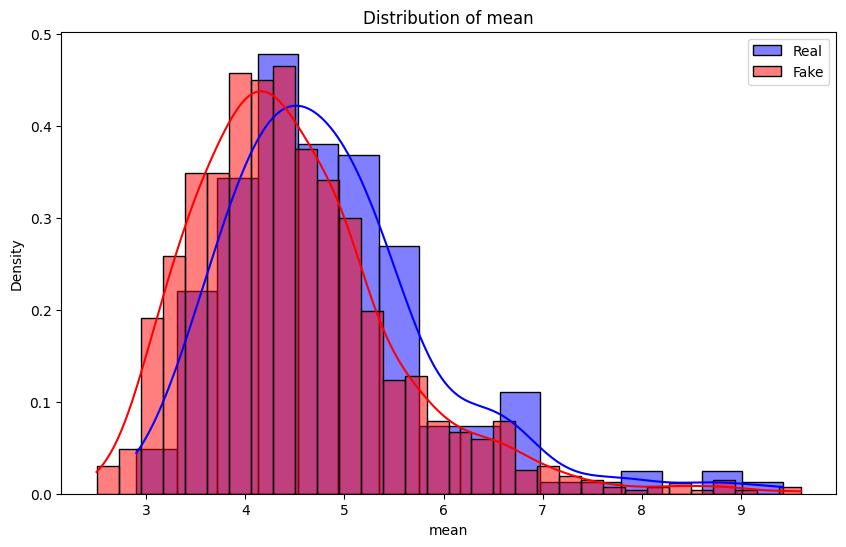

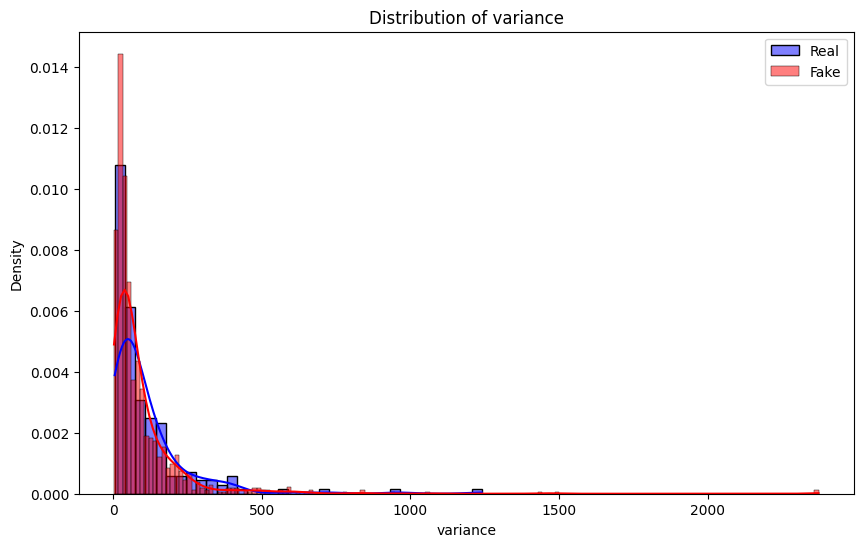

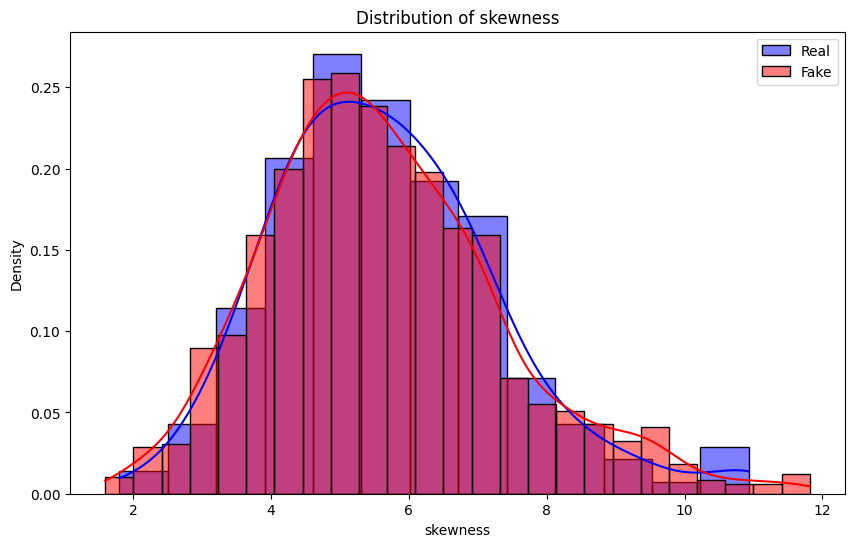

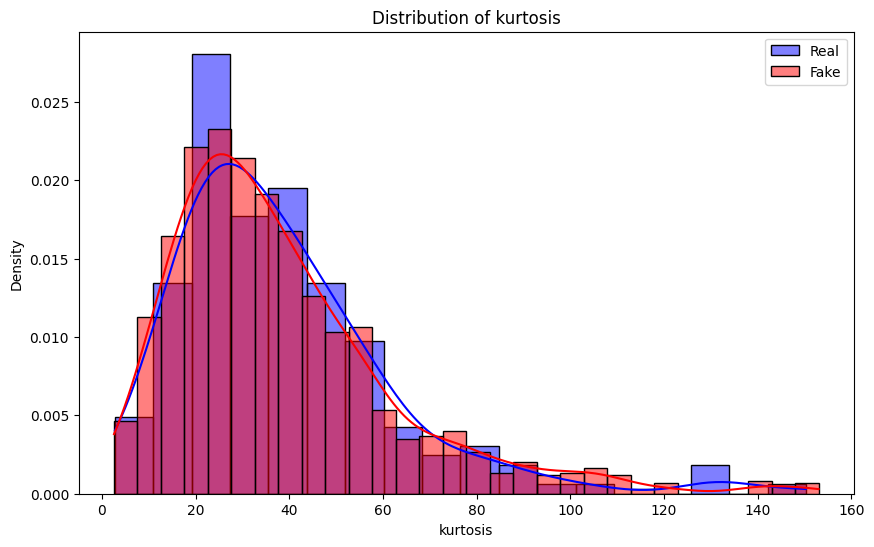

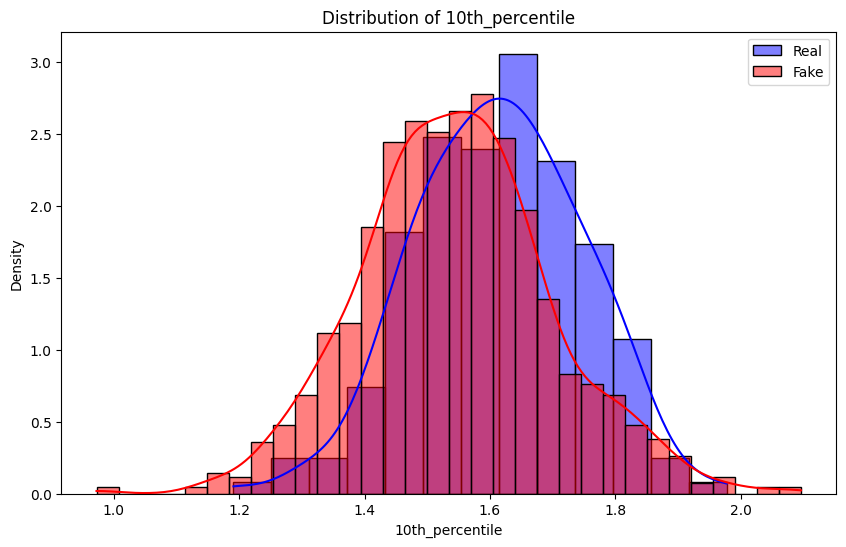

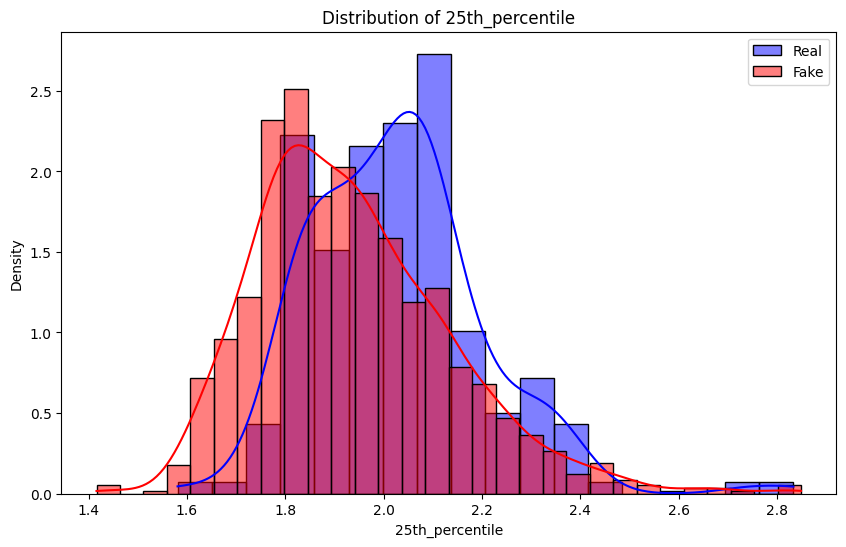

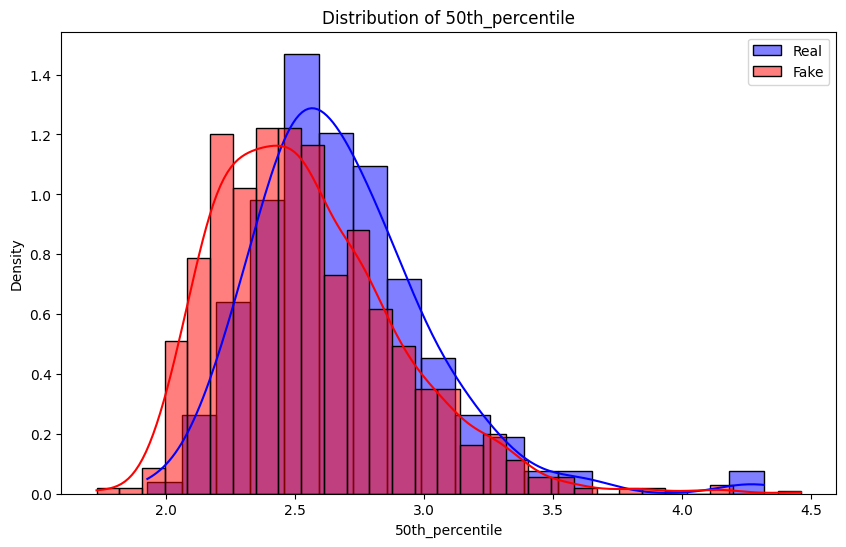

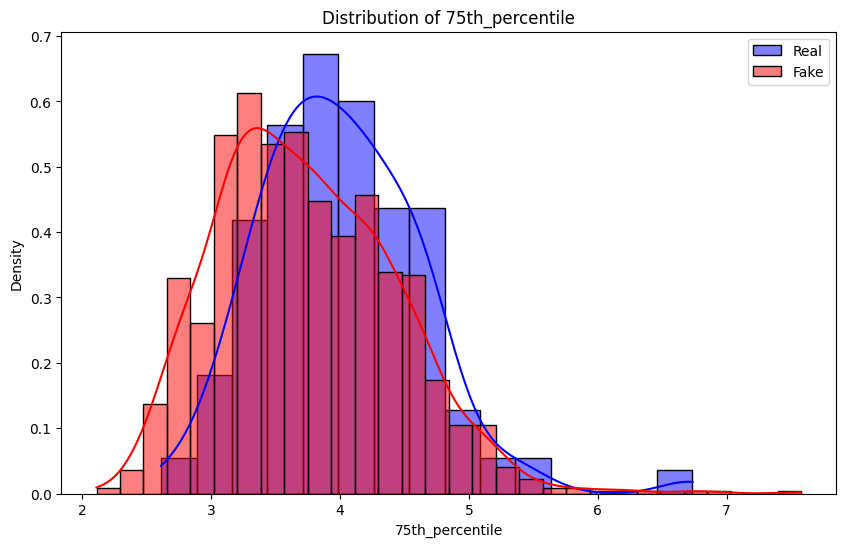

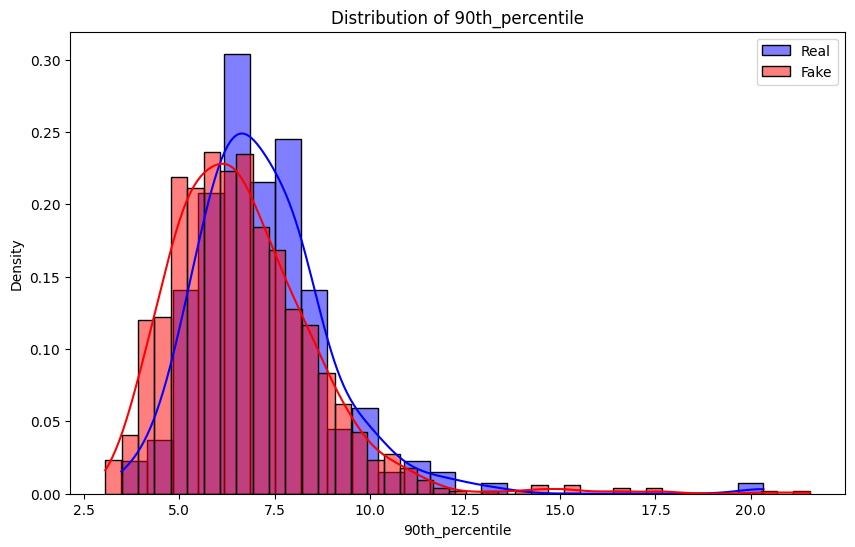

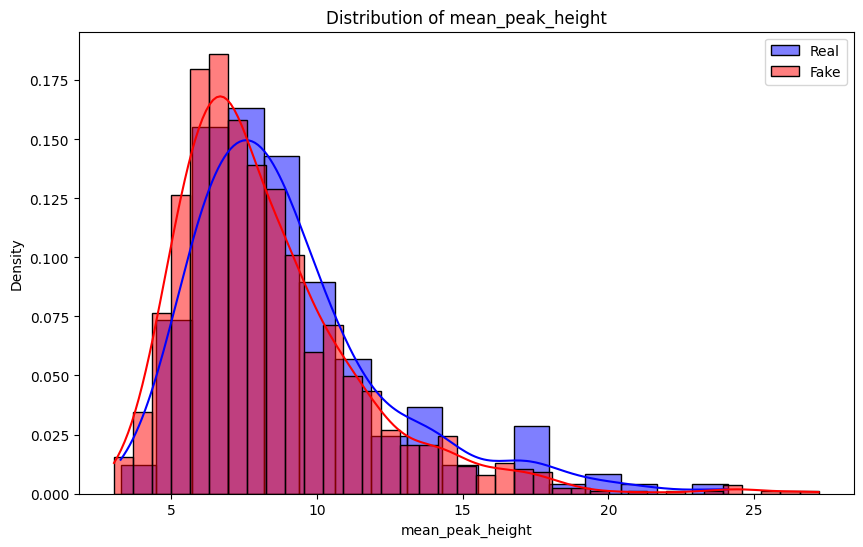

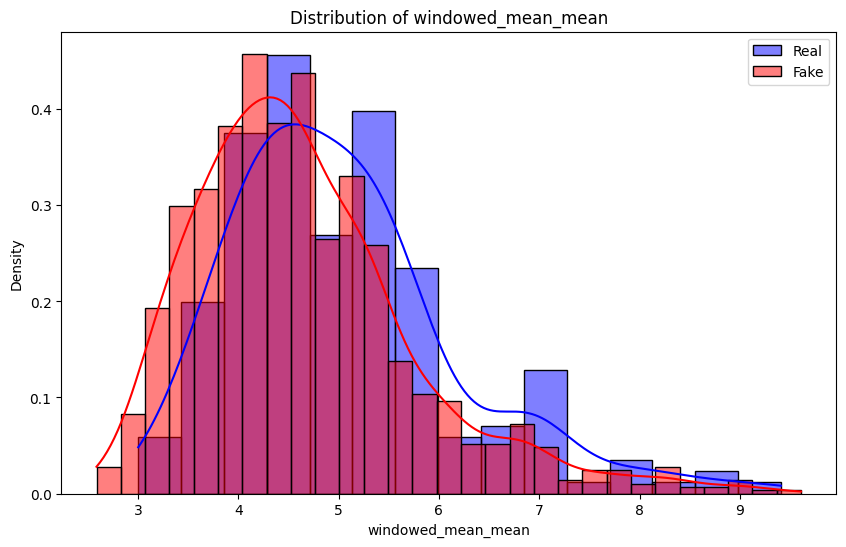

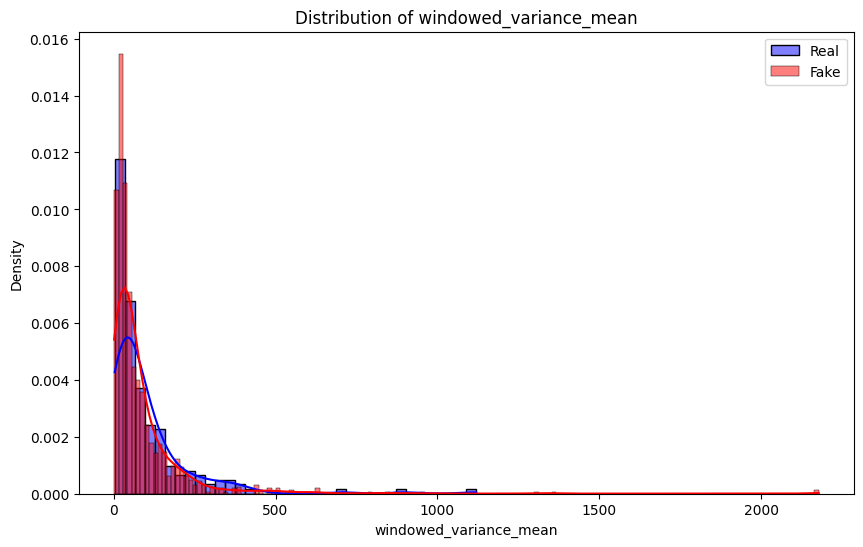

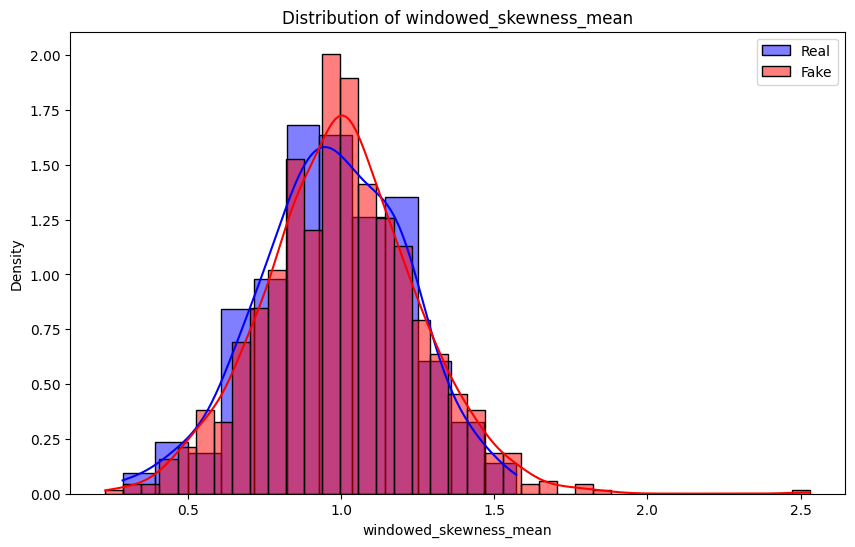

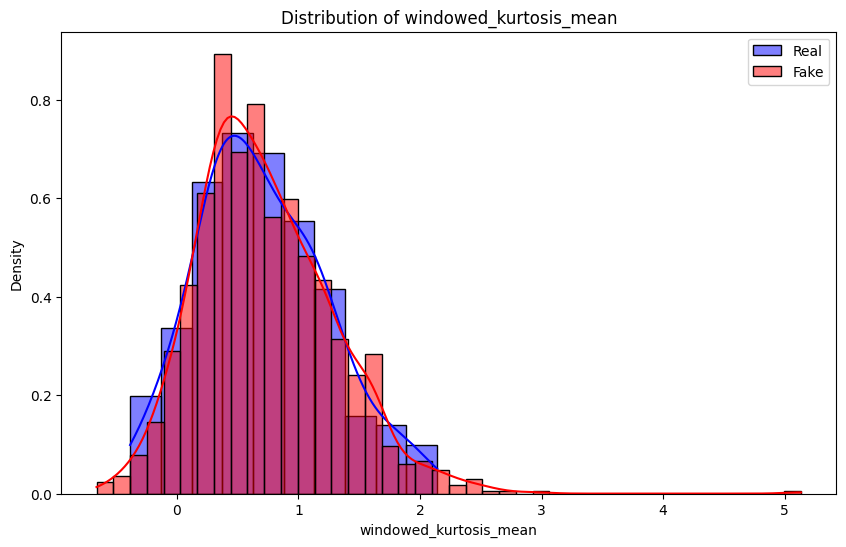

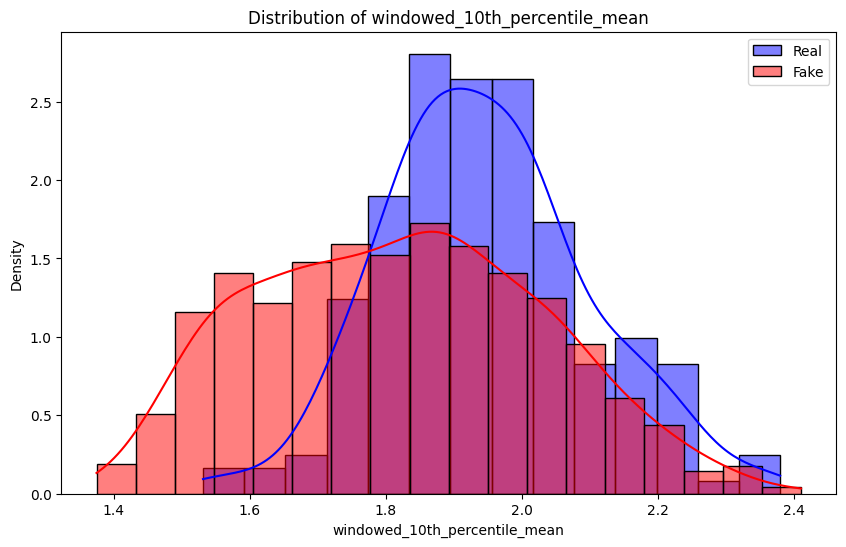

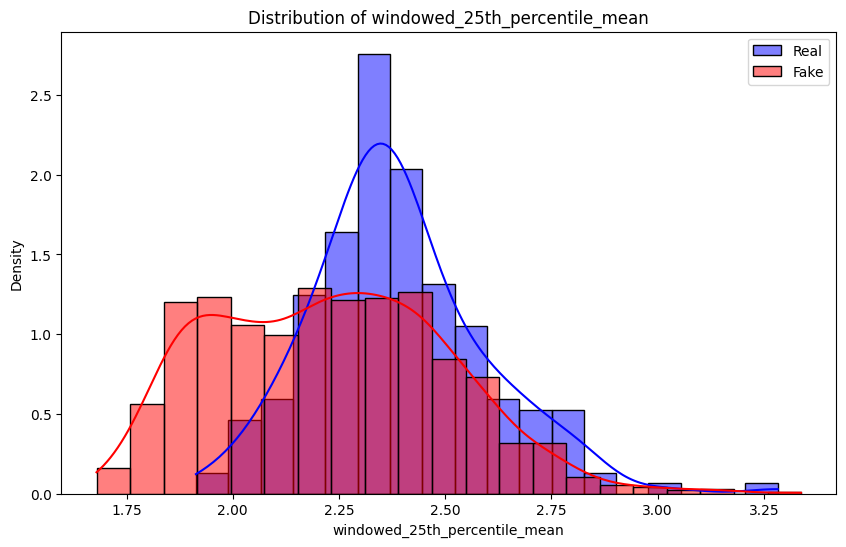

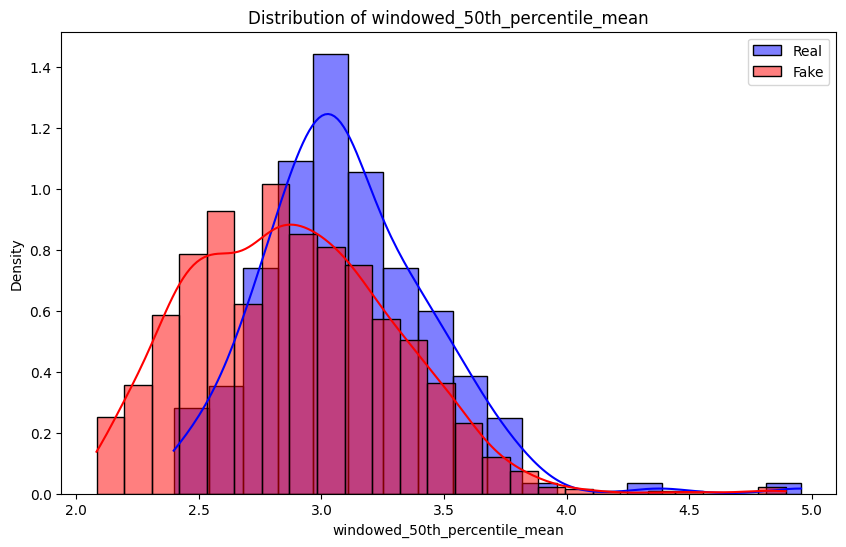

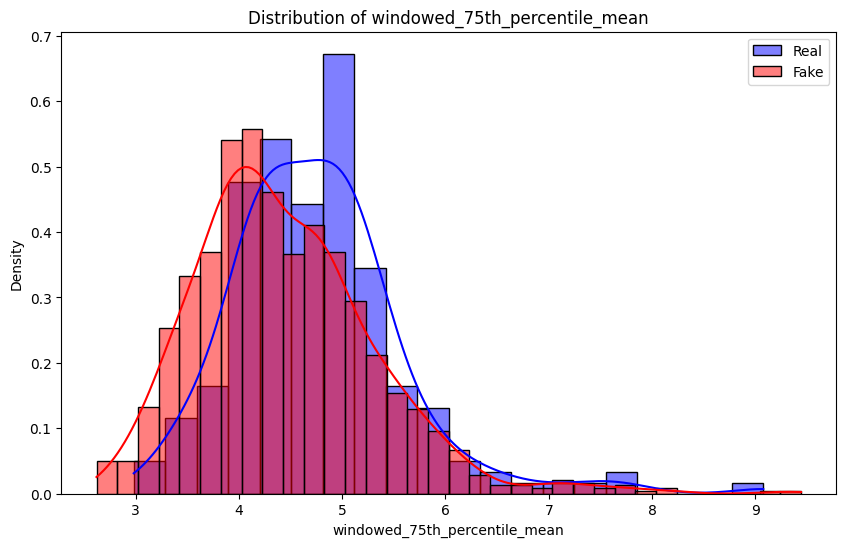

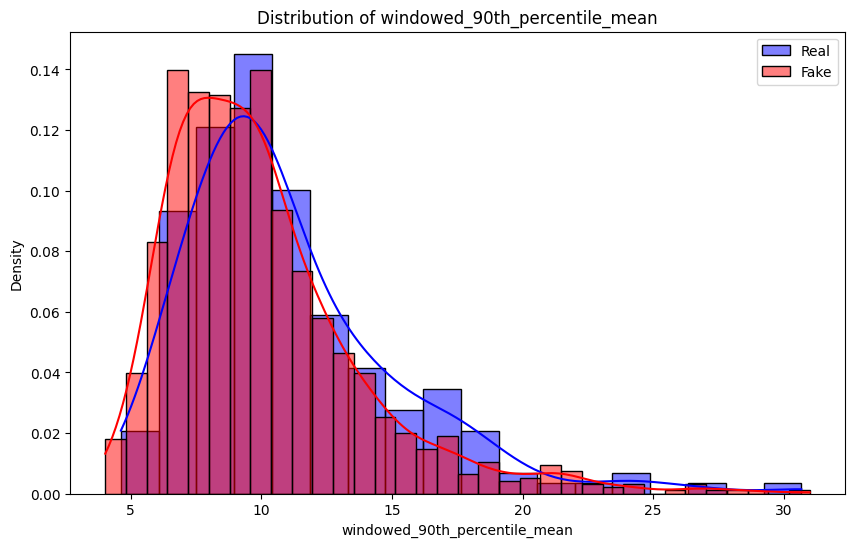

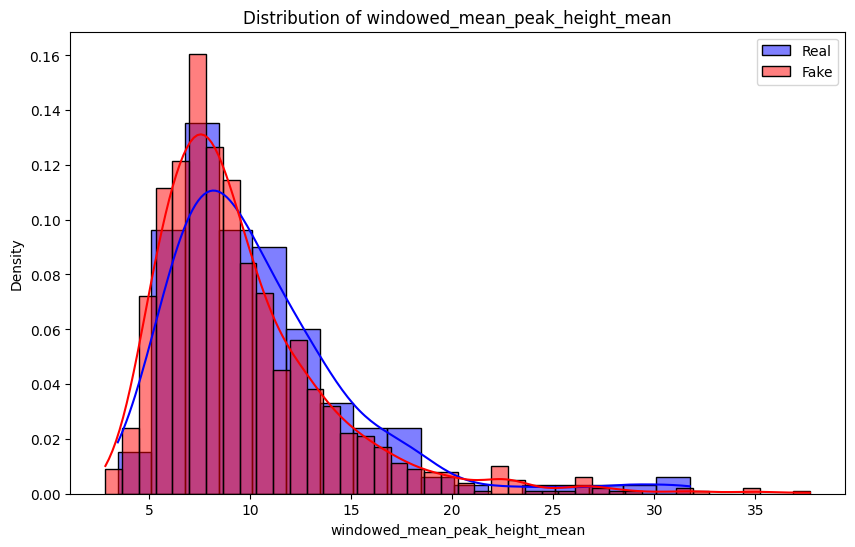

In [33]:
results = statistical_analysis(real_audio_values_list, fake_audio_values_list)

In [104]:
def get_top_n_features(feature_comparison, n=5):
    # Create a ranking for each test
    ttest_rank = {feature: rank for rank, (feature, _) in enumerate(sorted(feature_comparison.items(), key=lambda x: x[1]['p_value_ttest']))}
    mannwhitneyu_rank = {feature: rank for rank, (feature, _) in enumerate(sorted(feature_comparison.items(), key=lambda x: x[1]['p_value_mannwhitneyu']))}

    # Combine the ranks
    combined_rank = {feature: ttest_rank[feature] + mannwhitneyu_rank[feature] for feature in feature_comparison.keys()}

    # Sort features by the combined rank
    sorted_features = sorted(combined_rank.items(), key=lambda x: x[1])

    # Select the top n features
    top_n_features = {feature: feature_comparison[feature] for feature, _ in sorted_features[:n]}

    return top_n_features

top_n_features = get_top_n_features(results, n=5)
pd.DataFrame(top_n_features)

,windowed_10th_percentile_mean,windowed_25th_percentile_mean,windowed_50th_percentile_mean,25th_percentile,10th_percentile
t_stat,1.023361e+01,9.688691e+00,8.063247e+00,6.624742e+00,5.954018e+00
p_value_ttest,1.335170e-21,1.093183e-19,1.776331e-14,1.677867e-10,3.304142e-09
u_stat,1.631190e+05,1.621970e+05,1.589620e+05,1.565910e+05,1.535800e+05
p_value_mannwhitneyu,3.770202e-16,1.567038e-15,1.833534e-13,4.762272e-12,2.243621e-10


In [105]:
def extract_features(values, agg_feature_names, windowed_feature_names):
    features = {}
    if windowed_feature_names:
        features_win = calculate_windowed_statistics(
            values, 
            windowed_features=windowed_feature_names
        )
        features.update(features_win)

    if agg_feature_names:
        features_agg = calculate_statistics(values, features=agg_feature_names)
        features.update(features_agg)
    return features

In [106]:
all_features = []

agg_feature_names      = ['25th_percentile', '10th_percentile']
windowed_feature_names =['windowed_10th_percentile_mean', 'windowed_25th_percentile_mean', 'windowed_50th_percentile_mean']

for real_crest_factor_waveform in real_audio_values_list:
    real_features = extract_features(
        real_crest_factor_waveform, 
        agg_feature_names, 
        windowed_feature_names
    )
    real_features['label'] = 'real'
    all_features.append(real_features)

for fake_crest_factor_waveform in fake_audio_values_list:
    fake_features = extract_features(
        fake_crest_factor_waveform, 
        agg_feature_names, 
        windowed_feature_names
    )
    fake_features['label'] = 'fake'
    all_features.append(fake_features)

In [107]:
features_df = pd.DataFrame(all_features)
features_df.head()

,windowed_10th_percentile_mean,windowed_25th_percentile_mean,windowed_50th_percentile_mean,25th_percentile,10th_percentile,label
0,1.717953,2.163193,2.854717,1.985586,1.614970,real
1,1.913511,2.437713,3.356465,2.200293,1.728260,real
2,2.238768,2.696795,3.409085,2.423605,1.809683,real
3,1.871829,2.343448,3.046105,2.063920,1.498101,real
4,1.950994,2.409640,3.057586,1.948027,1.576681,real


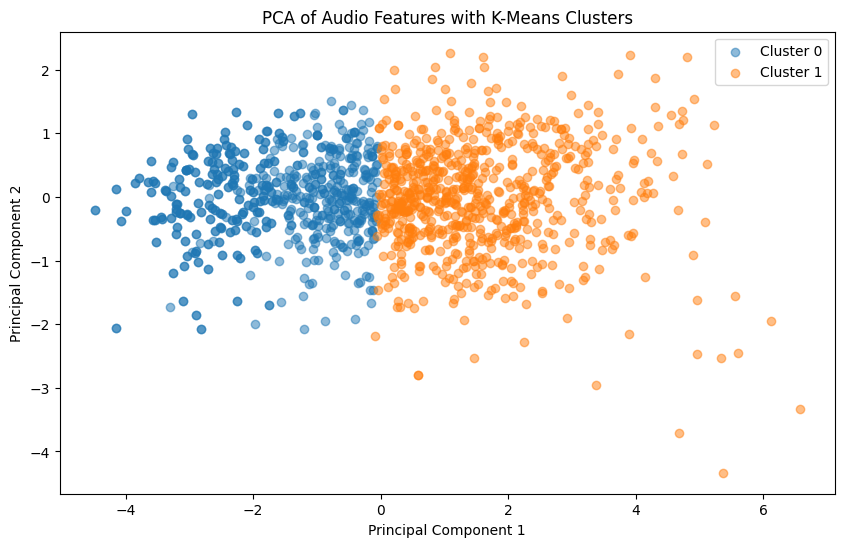

Confusion Matrix:
 [[ 48 152]
 [631 569]]

Classification Report:
               precision    recall  f1-score   support

        real       0.07      0.24      0.11       200
        fake       0.79      0.47      0.59      1200

    accuracy                           0.44      1400
   macro avg       0.43      0.36      0.35      1400
weighted avg       0.69      0.44      0.52      1400



In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report


# Standardize the features
features = features_df.drop(columns=['label'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Create a DataFrame with the K-Means results
kmeans_df = pd.DataFrame(features_scaled, columns=features.columns)
kmeans_df['label'] = features_df['label'].map({'real': 0, 'fake': 1})
kmeans_df['cluster'] = kmeans_labels

# Perform PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['label'] = features_df['label'].map({'real': 0, 'fake': 1})
pca_df['cluster'] = kmeans_labels

# Plot the PCA results with K-Means clusters
plt.figure(figsize=(10, 6))
for cluster in pca_df['cluster'].unique():
    subset = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', alpha=0.5)

plt.title('PCA of Audio Features with K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Compare cluster labels with true labels
confusion_mat = confusion_matrix(kmeans_df['label'], kmeans_df['cluster'])
print("Confusion Matrix:\n", confusion_mat)

# Calculate and print classification report
report = classification_report(kmeans_df['label'], kmeans_df['cluster'], target_names=['real', 'fake'])
print("\nClassification Report:\n", report)


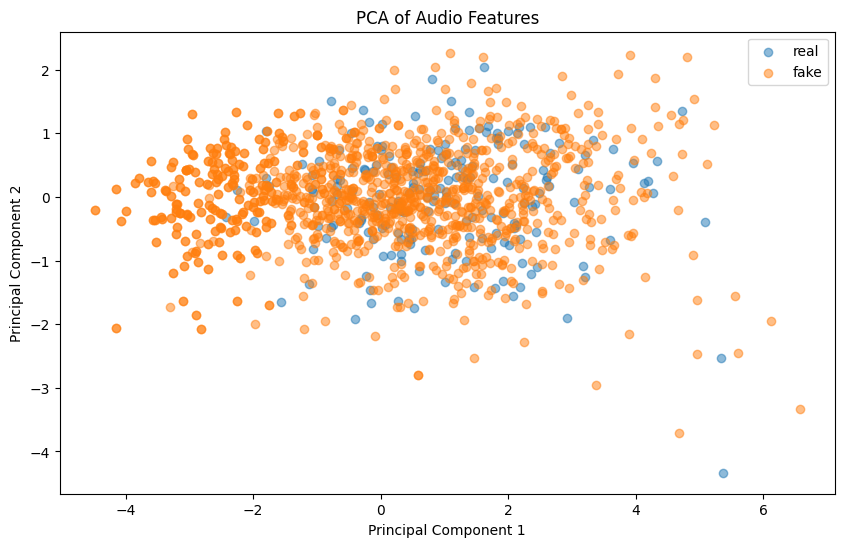

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Standardize the features
features = features_df.drop(columns=['label'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['label'] = features_df['label']

# Plot the PCA results
plt.figure(figsize=(10, 6))
for label in ['real', 'fake']:
    subset = pca_df[pca_df['label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, alpha=0.5)

plt.title('PCA of Audio Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


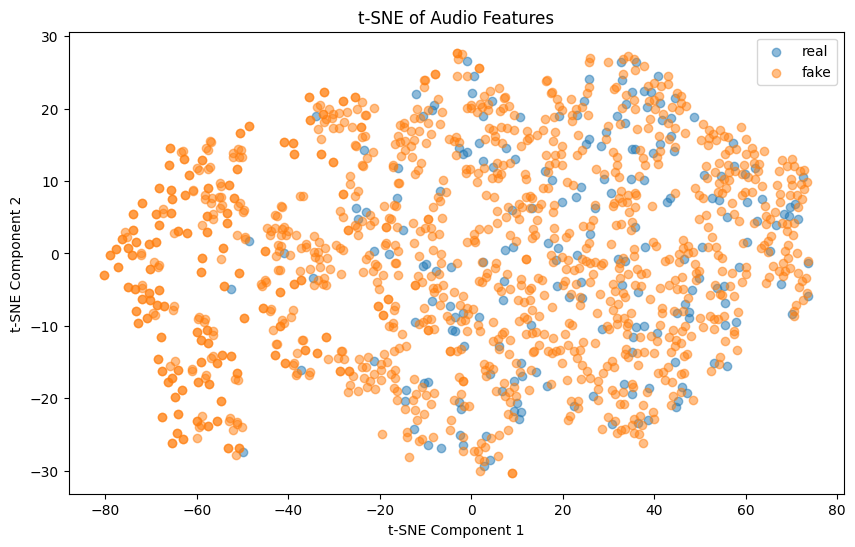

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Standardize the features
features = features_df.drop(columns=['label'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(features_scaled)

tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = features_df['label']

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=label, alpha=0.5)

plt.title('t-SNE of Audio Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


/tmp/ipykernel_47/3946721310.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  correlation_matrix = features_df.replace({'label': {'real': 0, 'fake': 1}}).corr()


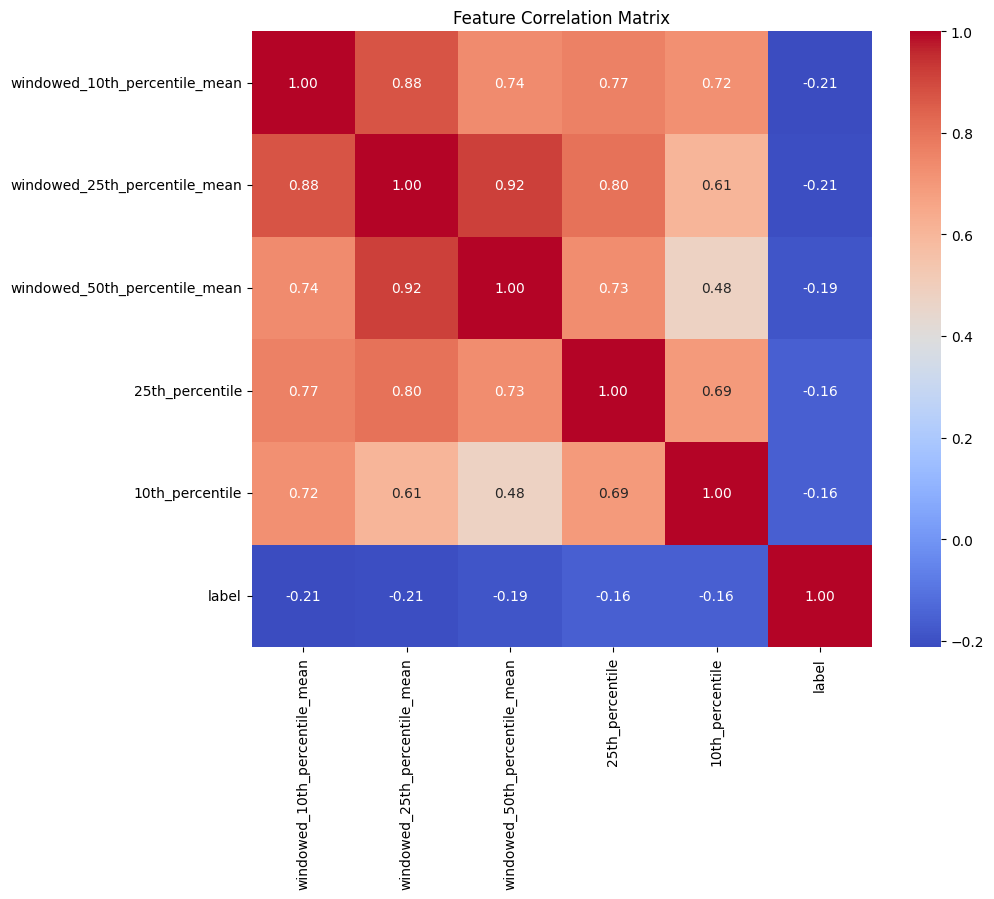

In [114]:
### Identify Multicollinearity

correlation_matrix = features_df.replace({'label': {'real': 0, 'fake': 1}}).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()